In [1]:
import warnings
import numpy as np
import pandas as pd

# settings
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# visualization
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# imbalance
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# data preprocessing and models
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, precision_recall_curve

# machine learning
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier

In [2]:
df = pd.read_csv("C:/Users/Настя/YandexDisk-n4skolesnikova/HSE 4th year/Graduation Thesis/data/PANEL_DATA.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)
df.head()

(2694303, 23)


,REGION,region_road,YEAR_MONTH,n_ACCIDENTS,MONTH,SEASON,YEAR,COVID_YEARS,HOLIDAYS,avg_ACC_in_REG_prev_year,...,n_pedestrian_violation_ACC_3m,n_impaired_driving_ACC_3m,n_maneuver_violation_ACC_3m,n_traffic_control_violation_ACC_3m,n_license_violation_ACC_3m,n_crossing_violation_ACC_3m,n_is_WEEKEND_ACC_3m,n_is_NIGHT_ACC_3m,n_is_PEAK_HOUR_ACC_3m,is_toll
0,10011,10011_11173,2016-01,0,1,1,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10011,10011_11173,2016-02,0,2,1,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10011,10011_11173,2016-03,0,3,2,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10011,10011_11173,2016-04,0,4,2,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10011,10011_11173,2016-05,0,5,2,2016,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0, 0.5, 'Число аварий')

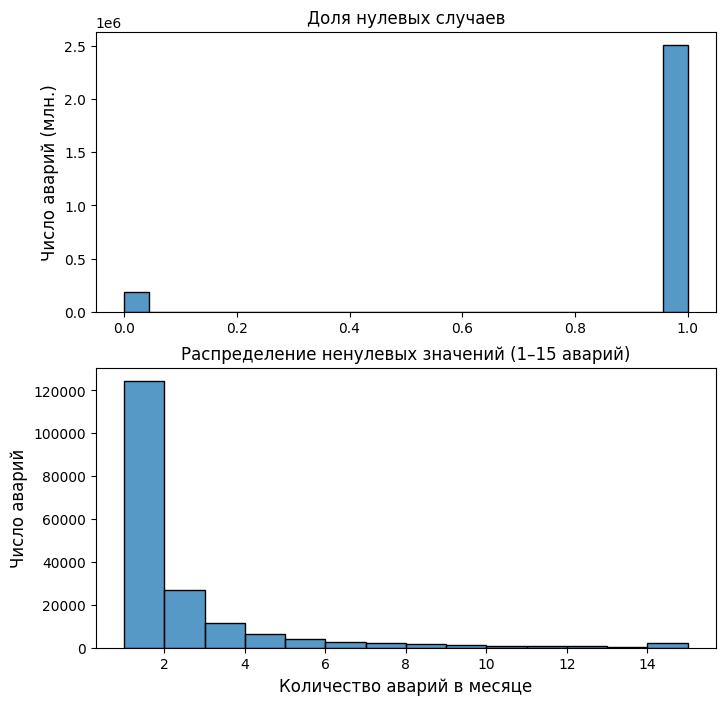

In [20]:
data = df['n_ACCIDENTS']

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=False)

sns.histplot(df['n_ACCIDENTS']==0, ax=axes[0])
axes[0].set_title('Доля нулевых случаев', fontsize=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Число аварий (млн.)', fontsize=12)

sns.histplot(data[data > 0].clip(upper=15), bins=range(1, 16), ax=axes[1])
axes[1].set_title('Распределение ненулевых значений (1–15 аварий)', fontsize=12)
axes[1].set_xlabel('Количество аварий в месяце', fontsize=12)
axes[1].set_ylabel('Число аварий', fontsize=12)


In [3]:
acc_hot_spots = pd.read_csv("C:/Users/Настя/YandexDisk-n4skolesnikova/HSE 4th year/Graduation Thesis/data/ACCIDENTS_HOT_SPOTS.csv")
acc_hot_spots = acc_hot_spots.drop('Unnamed: 0', axis=1)
print(acc_hot_spots.shape)
acc_hot_spots.head()

(440127, 4)


,REGION,road_name,is_HOT_SPOT,CLUSTER
0,3,М-4 Дон Москва - Воронеж - Ростов-на-Дону - Кр...,0,-1
1,3,М-4 Дон Москва - Воронеж - Ростов-на-Дону - Кр...,0,-1
2,3,Р-217 Кавказ автомобильная дорога М-4 Дон - Вл...,0,-1
3,3,М-4 Дон Москва - Воронеж - Ростов-на-Дону - Кр...,0,-1
4,3,Р-217 Кавказ автомобильная дорога М-4 Дон - Вл...,0,-1


In [4]:
le = LabelEncoder()
acc_hot_spots['road_name_encoded'] = le.fit_transform(acc_hot_spots['road_name'])
acc_hot_spots['region_road'] = acc_hot_spots['REGION'].astype(str) + '_' + acc_hot_spots['road_name_encoded'].astype(str)

In [5]:
hotspot_share = (
    acc_hot_spots
    .groupby('region_road')['is_HOT_SPOT']
    .mean()
    .reset_index(name='HOTSPOT_share')
)

df = df.merge(hotspot_share, on='region_road', how='left')

# Frequency predictor model

## Regression

In [ ]:
features_df = df.drop(['n_ACCIDENTS, HOTSPOT_share'], axis=1)
features_df = features_df.select_dtypes(include=['int64', 'float64'])
features = features_df.columns.to_list()

X = df[features]
y = df['n_ACCIDENTS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

MSE: 0.2255
MAE: 0.1425


На первый взгляд MSE≈0.23 и MAE≈0.15 кажутся небольшими, но в нашем случае это ни о чём не говорит: ведь большинство истинных y≈0, и «обмануть» модель, просто предсказывая нули, несложно. Достаточно сранить наше предсказание с принитивным предсказанием константы 0.

In [16]:
mae_baseline = mean_absolute_error(y_test, np.zeros_like(y_test))
print(f'MAE for 0 predictions: {mae_baseline:.4f}')
print(f"MAE model: {mae:.4f}")

MAE for 0 predictions: 0.1452
MAE model: 0.1425


In [17]:
mask = y_test > 0
mae_nonzero = mean_absolute_error(y_test[mask], y_pred[mask])
print(f"MAE на ненулевых: {mae_nonzero:.4f}")

MAE на ненулевых: 1.2141


Попробуем несколько способов в нашем конкретном случае.

### Логарифмирование таргета

In [ ]:
df['y_log'] = np.log1p(df['n_ACCIDENTS'])

X = df[features]
y = df['y_log']
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42)
xgb_model.fit(X_train, y_train_log)
y_pred_log = xgb_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

MSE: 0.2359
MAE: 0.1278


In [19]:
mask = y_test > 0
mae_nonzero = mean_absolute_error(y_test[mask], y_pred[mask])
print(f"MAE на ненулевых: {mae_nonzero:.4f}")

MAE на ненулевых: 1.2780


MAE не просто не упал, а вырос на ненулевых значениях. Поэтому попробуем поменять постановку задачи.

## Classification 

In [13]:
df['ACCIDENT_bin'] = (df['n_ACCIDENTS'] > 0).astype(int)

print(f"Percent of obs with accidents: {round(df['ACCIDENT_bin'].value_counts()[1] / df.shape[0], 3)}%")

Percent of obs with accidents: 0.069%


Наблюдаем огромный дисбаланс классов, минорный класс меньше десятой части процента. Для сравнения попробуем обучить модель на таких данных (и посмотреть на достоверные метрики) и после сделать oversampling.

In [38]:
# features_df = df.drop(['n_ACCIDENTS', 'HOTSPOT_share'], axis=1)
features_df = df.drop(['n_ACCIDENTS'], axis=1)
features_df = features_df.select_dtypes(include=['int64', 'float64'])
features = features_df.columns.to_list()

X = df[features]
y = df['ACCIDENT_bin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("MCC: ", matthews_corrcoef(y_test, y_pred))

Accuracy:  0.9461809260644211
F1:  0.45494013945533485
MCC:  0.47323821383666237


In [39]:
features_df = df.drop(['n_ACCIDENTS', 'HOTSPOT_share'], axis=1)
# features_df = df.drop(['n_ACCIDENTS'], axis=1)
features_df = features_df.select_dtypes(include=['int64', 'float64'])
features = features_df.columns.to_list()

X = df[features]
y = df['ACCIDENT_bin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("MCC: ", matthews_corrcoef(y_test, y_pred))

Accuracy:  0.9457596671497844
F1:  0.44769463340891913
MCC:  0.46708044876464877


Модель правильно классифицирует примерно 94.6 % всех месяцев. Но из‑за сильного перекоса классов (большинство месяцев без ДТП), как мы уже поняли, даже «глупый» классификатор, постоянно предсказывающий 0, даст очень высокую точность. Поэтому смотрим на другие метрики.

F1 — это гармоническое среднее precision и recall для положительного класса (месяцы с хотя бы одним ДТП). Значение ~0.45 говорит о том, что модель находит далеко не все аварийные месяцы (не слишком высокая полнота) и при этом ещё ошибается, помечая некоторые «чистые» месяцы как аварийные (precision тоже не идеален).

Matthews Corrcoef — «сбалансированная» метрика, которая учитывает TP, TN, FP и FN одновременно и устойчиво реагирует на дисбаланс классов. Значение ~0.47 указывает на умеренную положительную корреляцию предсказаний с реальностью (1.0 было бы идеалом, 0 — случайному угадыванию).

#### RandomOverSampler

In [40]:
sm = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)
y_pred = xgb_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("MCC: ", matthews_corrcoef(y_test, y_pred))

print(f"\nConfusion_matrix:\n {confusion_matrix(y_test, y_pred)}")

Accuracy:  0.8804793815102596
F1:  0.4131288555989903
MCC:  0.3791487405847665

Confusion_matrix:
 [[451787  49970]
 [ 14435  22669]]


### SMOTE (smart oversampling)

In [41]:
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)
y_pred = xgb_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("MCC: ", matthews_corrcoef(y_test, y_pred))

print(f"\nConfusion_matrix:\n {confusion_matrix(y_test, y_pred)}")

Accuracy:  0.8815241778492041
F1:  0.41141002710526803
MCC:  0.37618542717968395

Confusion_matrix:
 [[452707  49050]
 [ 14792  22312]]


#### Подберём наилучший порог для классификации

In [ ]:
probs = xgb_model.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * precision * recall / (precision + recall)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print("Лучший порог:", best_thresh)

Лучший порог: 0.7915797


In [43]:
probs = xgb_model.predict_proba(X_test)[:, 1]
y_pred = (probs >= best_thresh).astype(int)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))
print("MCC: ", matthews_corrcoef(y_test, y_pred))

Accuracy:  0.9403352627115341
F1:  0.48117607190692124
MCC:  0.4610171285757074


Качество не очень. Посмотрим на разделимость данных в пространстве.

In [45]:
X_num = df.select_dtypes(include=['int64', 'float64'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

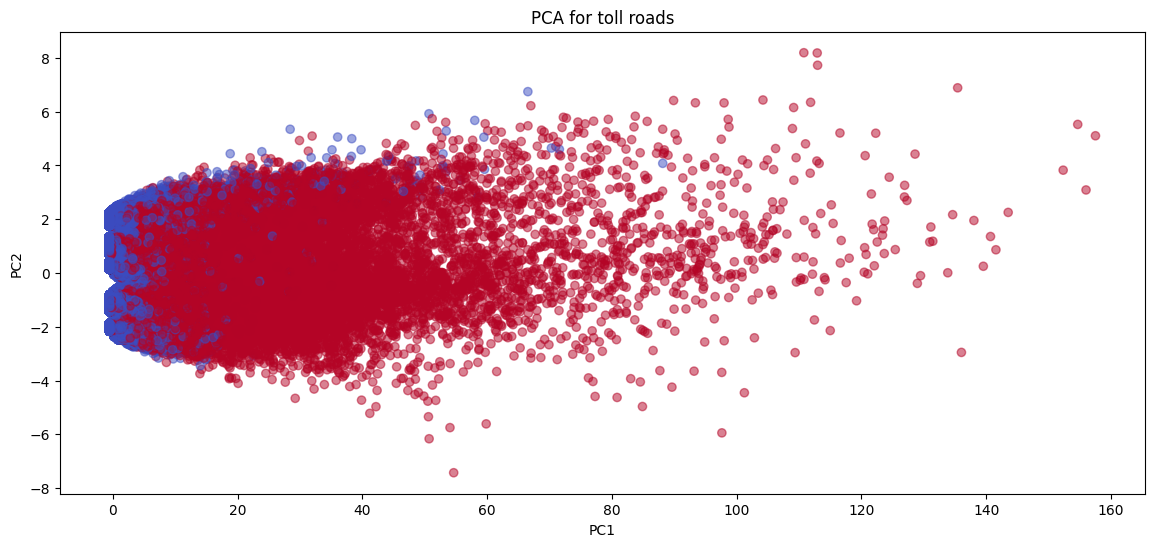

In [50]:
plt.figure(figsize=(14, 6))

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.5)

plt.title("PCA for toll roads")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

Вывод: с текущими признаками данные неразделимы. 

---
## Separate models for toll and free roads

### Toll roads

In [14]:
df_hypoth = df.drop(['REGION'], axis=1)

df_toll = df_hypoth[df_hypoth['is_toll'] == 1]
df_free = df_hypoth[df_hypoth['is_toll'] == 0]

In [ ]:
meaningful_df = df_hypoth.drop(['n_ACCIDENTS', 'HOTSPOT_share'], axis=1)
meaningful_df = meaningful_df.select_dtypes(include=['int64', 'float64'])
features = meaningful_df.columns.to_list()

X_toll = df_toll[features]
y_toll = df_toll['ACCIDENT_bin']
X_train_toll, X_test_toll, y_train_toll, y_test_toll = train_test_split(X_toll, y_toll, test_size=0.2, random_state=42)


xgb_toll = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42)
xgb_toll.fit(X_train_toll, y_train_toll)
y_pred_toll = xgb_toll.predict(X_test_toll)

print("Toll model metrics:\n")
print("Accuracy: ", accuracy_score(y_test_toll, y_pred_toll))
print("F1: ", f1_score(y_test_toll, y_pred_toll))
print("MCC: ", matthews_corrcoef(y_test_toll, y_pred_toll))

print(f"\nConfusion_matrix:\n {confusion_matrix(y_test_toll, y_pred_toll)}")

Toll model metrics:

Accuracy:  0.9407407407407408
F1:  0.8535871156661785
MCC:  0.8173628957960339

Confusion_matrix:
 [[2592   75]
 [ 125  583]]


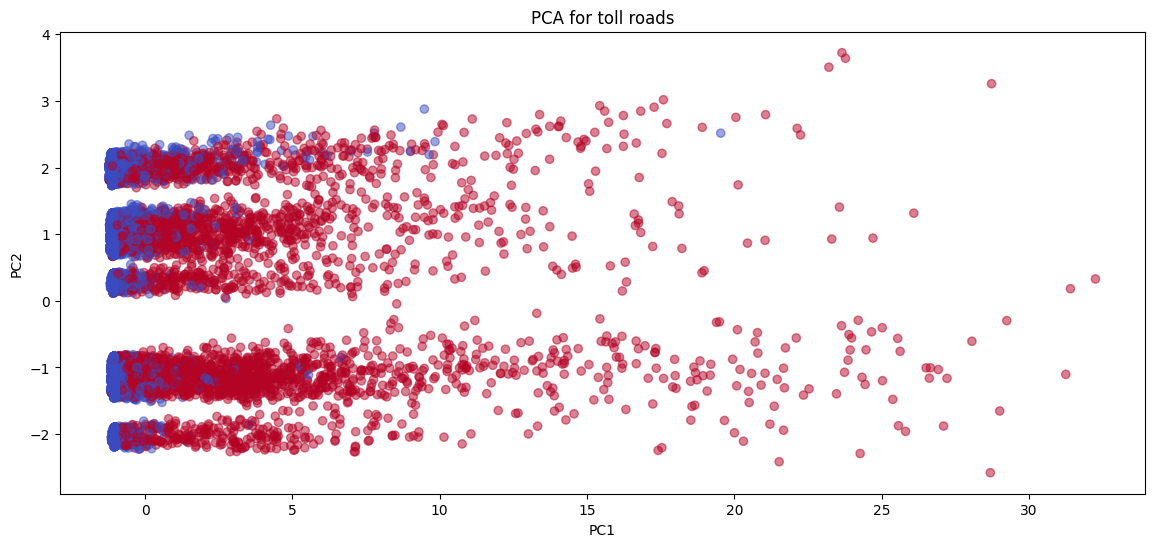

In [16]:
scaler = StandardScaler()
X_scaled_toll = scaler.fit_transform(X_toll)
pca = PCA(n_components=2)
X_pca_toll = pca.fit_transform(X_scaled_toll)

plt.figure(figsize=(14, 6))

plt.scatter(X_pca_toll[:,0], X_pca_toll[:,1], c=y_toll, cmap='coolwarm', alpha=0.5)

plt.title("PCA for toll roads")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

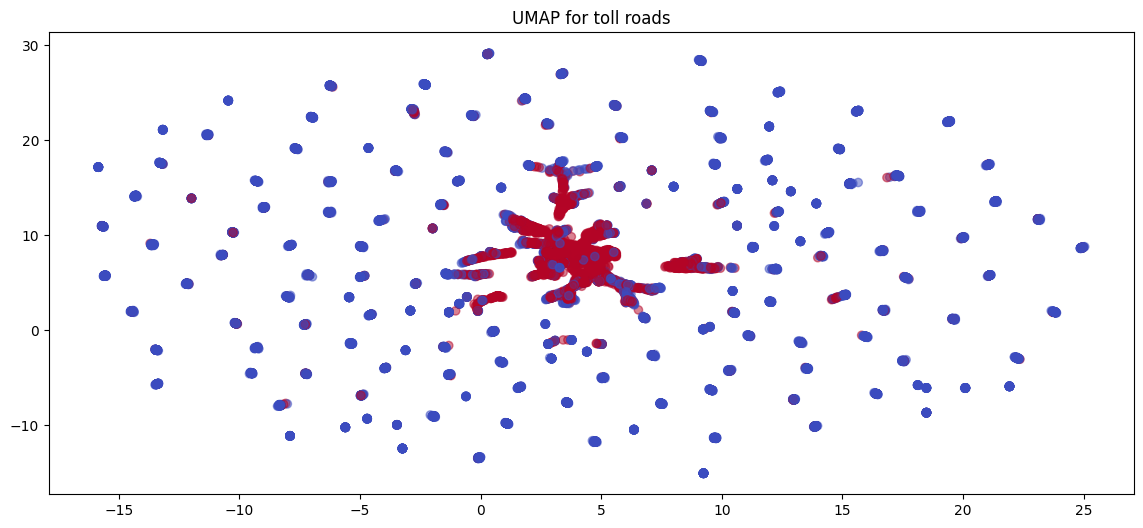

In [ ]:
reducer = umap.UMAP()
X_umap_toll = reducer.fit_transform(X_scaled_toll)

plt.figure(figsize=(14, 6))
plt.scatter(X_umap_toll[:,0], X_umap_toll[:,1], c=y_toll, cmap='coolwarm', alpha=0.5)

plt.title("UMAP for toll roads")
plt.show()

Видно, что данные хорошо разделимы в признаковои пространстве. 

In [34]:
probs = xgb_toll.predict_proba(X_test_toll)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test_toll, probs)
f1_scores = 2 * precision * recall / (precision + recall)
best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print("Лучший порог:", best_thresh)

Лучший порог: 0.36587128


In [35]:
y_pred_toll = (probs >= best_thresh).astype(int)

print("Toll model metrics after choosing the threshold:\n")
print("Accuracy: ", accuracy_score(y_test_toll, y_pred_toll))
print("F1: ", f1_score(y_test_toll, y_pred_toll))
print("MCC: ", matthews_corrcoef(y_test_toll, y_pred_toll))

print(f"\nConfusion_matrix:\n {confusion_matrix(y_test_toll, y_pred_toll)}")

Toll model metrics after choosing the threshold:

Accuracy:  0.9437037037037037
F1:  0.8633093525179856
MCC:  0.8281069466589204

Confusion_matrix:
 [[2585   82]
 [ 108  600]]


Удалось ещё совсем немного поднять качество.

---

### Free roads

In [24]:
X_free = df_free[features]
y_free = df_free['ACCIDENT_bin']
X_train_free, X_test_free, y_train_free, y_test_free = train_test_split(X_free, y_free, test_size=0.2, random_state=42)

xgb_free = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, subsample=0.8, random_state=42)
xgb_free.fit(X_train_free, y_train_free)
y_pred_free = xgb_free.predict(X_test_free)

print("Accuracy: ", accuracy_score(y_test_free, y_pred_free))
print("F1: ", f1_score(y_test_free, y_pred_free))
print("MCC: ", matthews_corrcoef(y_test_free, y_pred_free))

print(f"\nConfusion_matrix:\n {confusion_matrix(y_test_free, y_pred_free)}")

Accuracy:  0.9461200738766767
F1:  0.4450044242680722
MCC:  0.4660181915663448

Confusion_matrix:
 [[495068   3801]
 [ 25051  11567]]


---

### What can be the reason of such difference in results?

In [30]:
print(f"Number of obs total: {df.shape[0]}")
print(f"Percent of obs with accidents: {round(df['ACCIDENT_bin'].value_counts()[1] / df.shape[0], 3)}%")
print("--------------------\n")

print(f"Number of obs on toll roads: {df_toll.shape[0]}")
print(f"Imbalance of target on toll roads: {round(df_toll['ACCIDENT_bin'].value_counts()[1] / df_toll.shape[0], 3)}%")
print("--------------------\n")

print(f"Number of obs on free roads: {df_free.shape[0]}")
print(f"Imbalance on free roads: {round(df_free['ACCIDENT_bin'].value_counts()[1] / df_free.shape[0], 3)}%")

Number of obs total: 2694303
Percent of obs with accidents: 0.069%
--------------------

Number of obs on toll roads: 16872
Imbalance of target on toll roads: 0.233%
--------------------

Number of obs on free roads: 2677431
Imbalance on free roads: 0.068%


Text(0.5, 1.0, 'Free')

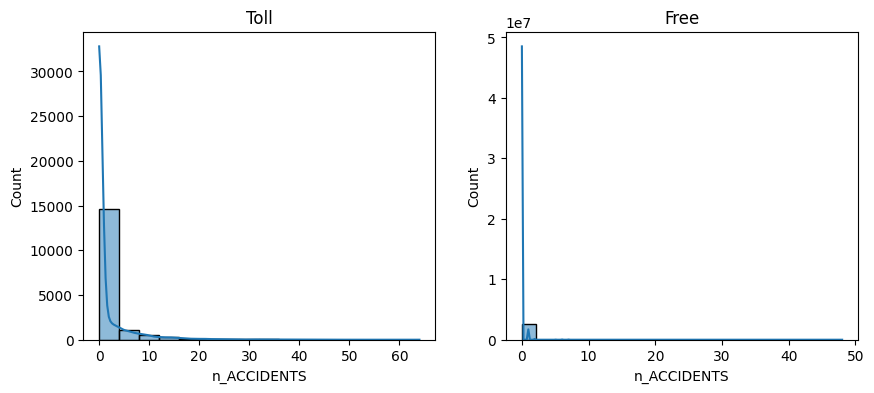

In [36]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.histplot(df[df.is_toll==1]['n_ACCIDENTS'], ax=axes[0], kde=True).set_title('Toll')
sns.histplot(df[df.is_toll==0]['n_ACCIDENTS'], ax=axes[1], kde=True).set_title('Free')

As can be noticed, the imbalance on free roads and in common dataset is much more serious copmare to toll roads. 

In [41]:
y_arr = y_toll.to_numpy()
n0 = np.sum(y_arr == 0)
n1 = np.sum(y_arr == 1)
print(f"Counts on toll: 0 → {n0}, 1 → {n1}")
print(f"Toll Ratio 0/1: {n0/n1:.2f}")
print("\n--------------------\n")

y_arr = y_free.to_numpy()
n0 = np.sum(y_arr == 0)
n1 = np.sum(y_arr == 1)
print(f"Counts on free: 0 → {n0}, 1 → {n1}")
print(f"Free Ratio 0/1: {n0/n1:.2f}")

Counts on toll: 0 → 12938, 1 → 3934
Toll Ratio 0/1: 3.29

--------------------

Counts on free: 0 → 2495421, 1 → 182010
Free Ratio 0/1: 13.71


На платных дорогах модель «видит» в среднем 1 «положительный» пример на каждые ~3 «негативных» → легче учиться отличать. На бесплатных — примерно 1 к 14 → классификатор «забывает» про редкий класс и «прескакивает» в ноль, поэтому качество там гораздо хуже.

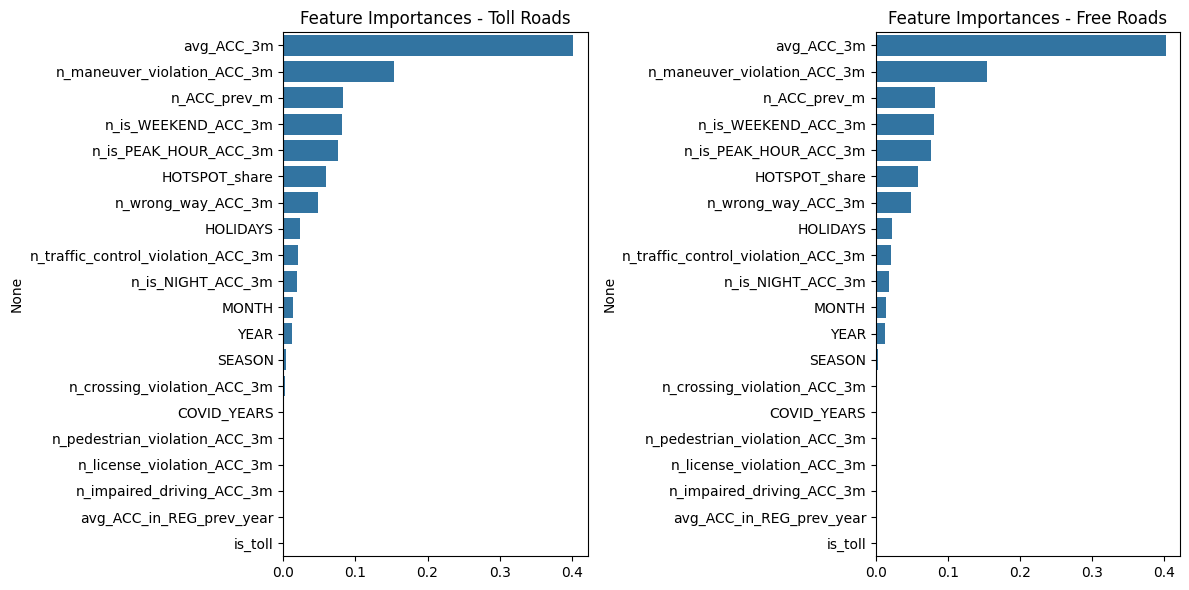

In [42]:
importances_toll = pd.Series(xgb_toll.feature_importances_, index=X_toll.columns).sort_values(ascending=False)
importances_free = pd.Series(xgb_free.feature_importances_, index=X_free.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=importances_toll.values, y=importances_toll.index)
plt.title("Feature Importances - Toll Roads")

plt.subplot(1, 2, 2)
sns.barplot(x=importances_free.values, y=importances_free.index)
plt.title("Feature Importances - Free Roads")

plt.tight_layout()
plt.show()

Так как признак `'avg_ACC_3m'` и другие "исторические" признаки являются наболее значимыми для предсказания, можно предположить, что для бесплатных дорог нужно увеличить "окно", в захватываниии признаков, а также обогатить признаки другими полезными вещами, например, информацией о погоде и температуре за месяц.